In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn import ensemble

from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm, AnovaRM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot

from patsy import dmatrices

In [ ]:
resale = pd.read_csv('/content/gdrive/MyDrive/DSA3101 Group 9/Group Assignment 1/Data/resale(2017).csv')

# only choosing flats with 3/4/5 rooms and executive
resale = resale.loc[resale['flat_type'].isin(['3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE'])]
          
resale.head(n = 3)

In [ ]:
# exclude variables 
resale.drop(columns = ['block', 'street_name', 'lease_commence_date', 'month', 'addr', 'remaining_lease',
                      'nearby_mrt', 'nearby_hawker', 'nearby_park', 'nearby_school', 'nearby_supermarket', 'count_nearby_supermarket'], 
            inplace = True)

resale.drop(columns = ['district', 'storey_coded'], 
            inplace = True)

**Discete Variables**

Check for presence of multicollinearity.

From our correlation matrix of discrete variables, we observe that there is no strong collinearity between the data at pair-wise level. We have also calculated the Variance Inflation Factor to check for multicollinearity between more than 2 variables. We can conclude that there is no multicollinearity as evidenced by the small VIF values calculated.

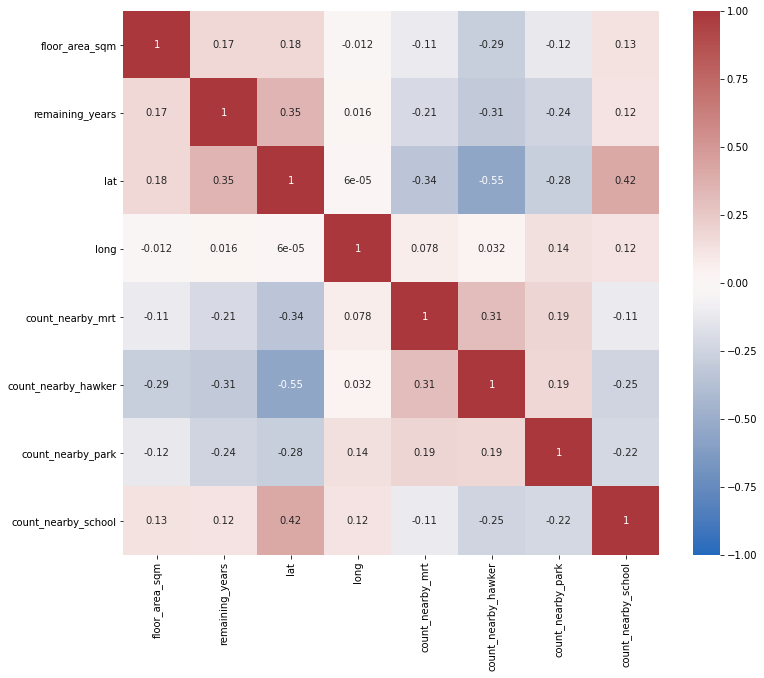

In [ ]:
resale_x = resale.copy()
resale_x.drop(columns = ['resale_price'], inplace = True)
#plot correlation matrix
fig, ax = plt.subplots(figsize = [12,10])
correlation_mat = resale_x.corr()
sns.heatmap(correlation_mat, annot = True, vmin=-1, vmax=1, cmap = "vlag")
plt.show()

In [ ]:
# gather discrete variables
resale_X = resale.copy()
variables = "+".join(resale_X.drop(['resale_price', 'Region', 'storey_range', 'town', 'flat_model', 'flat_type'],axis=1).columns)

# get each variables in the form of matrix
y, X = dmatrices('resale_price ~' + variables, resale_X, return_type='dataframe')

# For each variable, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["Variables"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# rounding off to 3.d.p
vif[1:9].round(3)

,Variables,VIF Factor
1,floor_area_sqm,1.107
2,remaining_years,1.217
3,lat,1.811
4,long,1.054
5,count_nearby_mrt,1.183
6,count_nearby_hawker,1.575
7,count_nearby_park,1.176
8,count_nearby_school,1.268


**Categorical variables**

Check for presence of multicollinearity. 

From our Cramer's V matrix of categorical variables, we observe that there is a strong association between region and town, as well as flat_model and flat_type.

We drop region and flat_model.

In [ ]:
# filter out categorical variables
resale_cat = resale_x[['town', 'flat_type', 'storey_range', 'flat_model', 'Region']]

In [ ]:
# function to measure the association between categorical variables
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

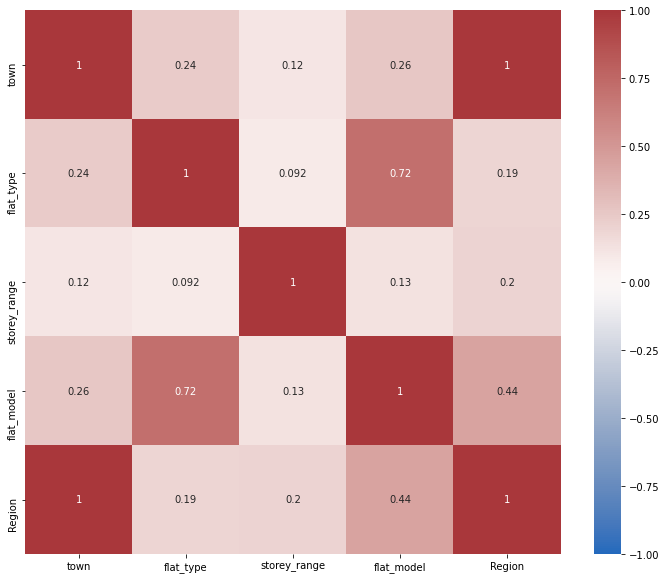

In [ ]:
matrix = np.zeros((5,5))

for i in range(0,5):
  for j in range(0,5):
    matrix[i][j] = cramers_v(resale_cat[resale_cat.columns[i]], resale_cat[resale_cat.columns[j]])
#correlation matrix for catagorical variables
matrix = pd.DataFrame(matrix)
matrix.index = ['town', 'flat_type', 'storey_range', 'flat_model', 'Region']
matrix.columns = ['town', 'flat_type', 'storey_range', 'flat_model', 'Region']

fig, ax = plt.subplots(figsize = [12,10])
sns.heatmap(matrix, annot = True, vmin=-1, vmax=1, cmap = "vlag")
plt.show()

**Categorical - Continuous variables correlation**

Check for presence of multicollinearity.

We observe that flat_type and floor_area_sqm has a strong correlation.

We drop flat_type.

In [ ]:
# Factorising Categorical Variables before finding correlation
resale_cur = resale.copy()
categorical_variables = ['town', 'flat_type', 'storey_range', 'flat_model', 'Region']
continuous_variables =  ['floor_area_sqm', 'remaining_years', 'lat', 'long', 'count_nearby_mrt', 'count_nearby_hawker', 'count_nearby_park', 'count_nearby_school']

for col in categorical_variables:
    resale_cur[col] = pd.factorize(resale_cur[col], sort = True)[0]

# showing each categorical levels and their representation
for col in categorical_variables:
    data = {}
    data[col] = resale[col].unique()
    data['factorised ' + col] = resale_cur[col].unique()
    display(pd.DataFrame(data)) 

,town,factorised town
0,ANG MO KIO,0
1,BEDOK,1
2,BISHAN,2
3,BUKIT BATOK,3
4,BUKIT MERAH,4
5,BUKIT PANJANG,5
6,BUKIT TIMAH,6
7,CENTRAL AREA,7
8,CHOA CHU KANG,8
9,CLEMENTI,9


,flat_type,factorised flat_type
0,3 ROOM,0
1,4 ROOM,1
2,EXECUTIVE,3
3,5 ROOM,2


,storey_range,factorised storey_range
0,01 TO 03,0
1,07 TO 09,2
2,10 TO 12,3
3,04 TO 06,1
4,13 TO 15,4
5,28 TO 30,9
6,16 TO 18,5
7,22 TO 24,7
8,19 TO 21,6
9,25 TO 27,8


,flat_model,factorised flat_model
0,new generation,9
1,adjoined flat,0
2,dbss,2
3,standard,14
4,improved,3
5,model a,6
6,apartment,1
7,simplified,13
8,premium apartment,10
9,model a-maisonette,7


,Region,factorised Region
0,RCR,2
1,OCR,1
2,CCR,0


In [ ]:
# Find Point biserial correlation
matrix = np.zeros((8,5))
correlations = []
for cat in range(len(categorical_variables)):
  for cont in range(len(continuous_variables)):
    cat_var = categorical_variables[cat]
    cont_var = continuous_variables[cont]
    data_cat = resale_cur[cat_var].to_numpy()
    data_cont = resale_cur[cont_var].to_numpy()

    corr, p_val = pointbiserialr(x = data_cat, y = data_cont)
    matrix[cont][cat] = corr
    correlations.append(corr)
    if np.abs(corr) >= 0.7:
      
      print(f'Categorical variable: {cat_var}, Continuous variable: {cont_var}, correlation: {corr}')

Categorical variable: flat_type, Continuous variable: floor_area_sqm, correlation: 0.9470260461417019


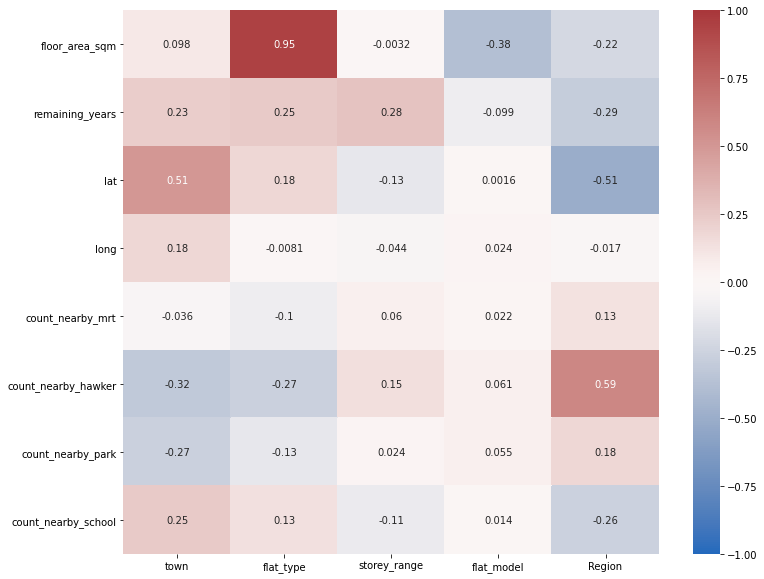

In [ ]:
#correlation matrix for catagorical variables
matrix = pd.DataFrame(matrix)
matrix.index = ['floor_area_sqm', 'remaining_years', 'lat', 'long', 'count_nearby_mrt', 'count_nearby_hawker', 'count_nearby_park', 'count_nearby_school']
matrix.columns = ['town', 'flat_type', 'storey_range', 'flat_model', 'Region']

fig, ax = plt.subplots(figsize = [12,10])
sns.heatmap(matrix, annot = True, vmin=-1, vmax=1, cmap = "vlag")
plt.show()

Updating the format for categorical features for the fitting of OLS model. We also drop region, flat_model and flat_type here.

In [ ]:
cat_features = ['town', 'storey_range']

for col in cat_features:
  cat = list(resale[col].unique())
  cat_dtype = pd.CategoricalDtype(categories = cat)
  resale[col] = resale[col].astype(cat_dtype)


# factorise the categorical variables
dummies = pd.get_dummies(resale[['town', 'storey_range']])

# drop unfactorised categorical variables
resaleX_ = resale.copy()
resaleX_.drop(['Region', 'town', 'storey_range', 'flat_type', 'flat_model'], axis = 1, inplace = True)

# join the discrete and categorical variables together
resale_new = pd.concat([resaleX_, dummies], axis = 1)

# renaming the column names OLS to work without any error
all = [''.join(col.split(' ')) for col in resale_new.columns]
all[23] = all[23].replace('/', '_')
all[23] = all[23].replace('-', '_')
resale_new.columns = all
resale_new

,floor_area_sqm,resale_price,remaining_years,lat,long,count_nearby_mrt,count_nearby_hawker,count_nearby_park,count_nearby_school,town_ANGMOKIO,town_BEDOK,town_BISHAN,town_BUKITBATOK,town_BUKITMERAH,town_BUKITPANJANG,town_BUKITTIMAH,town_CENTRALAREA,town_CHOACHUKANG,town_CLEMENTI,town_GEYLANG,town_HOUGANG,town_JURONGEAST,town_JURONGWEST,town_KALLANG_WHAMPOA,town_MARINEPARADE,town_PASIRRIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOAPAYOH,town_WOODLANDS,town_YISHUN,storey_range_01TO03,storey_range_07TO09,storey_range_10TO12,storey_range_04TO06,storey_range_13TO15,storey_range_28TO30,storey_range_16TO18,storey_range_22TO24,storey_range_19TO21,storey_range_25TO27,storey_range_34TO36,storey_range_31TO33,storey_range_37TO39,storey_range_40TO42,storey_range_46TO48,storey_range_43TO45,storey_range_49TO51
9,67.0,250000.0,59.932784,1.370966,103.838202,0,4,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,67.0,295000.0,59.847909,1.370966,103.838202,0,4,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,67.0,288000.0,59.100461,1.370966,103.838202,0,4,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,67.0,298000.0,59.100461,1.370966,103.838202,0,4,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,82.0,345000.0,58.520024,1.370966,103.838202,0,4,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105577,68.0,380000.0,95.353087,1.415288,103.839847,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105578,93.0,490000.0,95.353087,1.415288,103.839847,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105579,68.0,365000.0,94.353751,1.414707,103.842112,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105580,93.0,462000.0,95.353087,1.415819,103.840679,1,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# split into train, test, validation sets

target_y = resale_new['resale_price']
train_data, test_data, train_y, test_y = train_test_split(resale_new, target_y, test_size = 0.2, random_state = 1)
#Check size of train and test dataset
print("Train dataset has {} resale houses.".format(len(train_data)))
print("Test dataset has {} resale houses.".format(len(test_data)))
print("Total = {} houses.".format(len(resale)))

Train dataset has 83130 resale houses.
Test dataset has 20783 resale houses.
Total = 103913 houses.


In [ ]:
# we transform the resale price by performing log on its values
train_data['resale_price'] = np.log(train_data['resale_price'])
test_data['resale_price'] = np.log(test_data['resale_price'])
train_y = np.log(train_y)
test_y = np.log(test_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Ordinary Least Square Model**

This section involves:
1. Fitting the model
2. Checking for significance. We conducted F-test statistic to examine the significance of each attributes in the model using the Analysis of Variance (ANOVA) method.
3. Use the model to predict the resale price of the test and train data.
4. Evaluate the model using accuracy metrics - R squared score, MAE, MAPE and MSE.


In [ ]:
#fitting the model

all_predictors = "+".join(train_data.drop(['resale_price'],axis=1).columns)
regmodel = ols('resale_price ~ ' + all_predictors, data=train_data).fit()

print(regmodel.summary())

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                 1.185e+04
Date:                Wed, 15 Sep 2021   Prob (F-statistic):               0.00
Time:                        12:28:14   Log-Likelihood:                 62411.
No. Observations:               83130   AIC:                        -1.247e+05
Df Residuals:                   83080   BIC:                        -1.243e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -16.5198 

In [ ]:
# Check for the significance of each attributes in the model using the Analysis of Variance (ANOVA) method.
anova = anova_lm(regmodel)
anova

,df,sum_sq,mean_sq,F,PR(>F)
floor_area_sqm,1.0,3797.399597,3797.399597,290943.170128,0.000000e+00
remaining_years,1.0,716.972624,716.972624,54931.877102,0.000000e+00
lat,1.0,1731.507289,1731.507289,132661.893166,0.000000e+00
long,1.0,173.307917,173.307917,13278.232526,0.000000e+00
count_nearby_mrt,1.0,198.889312,198.889312,15238.187494,0.000000e+00
count_nearby_hawker,1.0,206.761297,206.761297,15841.310793,0.000000e+00
count_nearby_park,1.0,72.040304,72.040304,5519.470347,0.000000e+00
count_nearby_school,1.0,0.673201,0.673201,51.578246,6.937378e-13
town_ANGMOKIO,1.0,12.162482,12.162482,931.845825,1.577069e-203
town_BEDOK,1.0,44.104674,44.104674,3379.142322,0.000000e+00


In [ ]:
# These are the variables with high p-values, and are hence not significant in the model
anova[anova['PR(>F)']>0.05]

,df,sum_sq,mean_sq,F,PR(>F)
town_YISHUN,1.0,0.002451,0.002451,0.187796,0.664758
storey_range_46TO48,1.0,0.000077,0.000077,0.005891,0.938822
storey_range_43TO45,1.0,0.000018,0.000018,0.001381,0.970361


In [ ]:
#predicting for train and test dataset
lm1 = regmodel.predict(test_data.drop(columns = ['resale_price']))
lm2 = regmodel.predict(train_data.drop(columns = ['resale_price']))

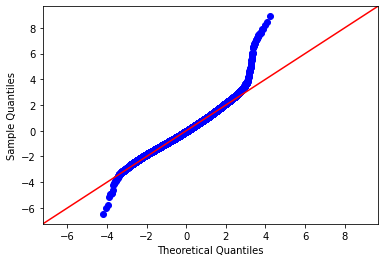

In [ ]:
#check QQplot of standard res
influence = regmodel.get_influence()
s_res = influence.resid_studentized_internal
QQplot  = qqplot(s_res, line = '45')

(array([1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        4.0000e+00, 1.0000e+00, 3.0000e+00, 6.0000e+00, 1.3000e+01,
        3.9000e+01, 1.0200e+02, 1.8900e+02, 4.7200e+02, 1.0550e+03,
        2.1390e+03, 3.9170e+03, 6.0590e+03, 8.3950e+03, 9.8940e+03,
        1.0646e+04, 1.0084e+04, 8.7440e+03, 7.0110e+03, 5.1810e+03,
        3.5380e+03, 2.3680e+03, 1.4180e+03, 9.1700e+02, 4.4400e+02,
        2.2700e+02, 1.0700e+02, 5.3000e+01, 2.3000e+01, 1.0000e+01,
        8.0000e+00, 1.1000e+01, 6.0000e+00, 3.0000e+00, 3.0000e+00,
        5.0000e+00, 0.0000e+00, 7.0000e+00, 6.0000e+00, 7.0000e+00,
        6.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-6.46416951, -6.15684442, -5.84951933, -5.54219424, -5.23486915,
        -4.92754406, -4.62021897, -4.31289388, -4.00556879, -3.6982437 ,
        -3.39091861, -3.08359352, -2.77626843, -2.46894333, -2.16161824,
        -1.85429315, -1.54696806, -1.23964297, -0.93231788, -0.62499279,
        -0.3176677 , -0.01

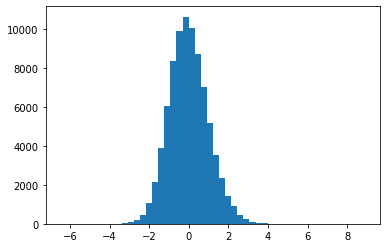

In [ ]:
#Check how many outliers are there, very small (89) in comparison to sample size(83130)
s_res_outlier = filter(lambda x: x < -4 or x > 4, s_res)
pd.DataFrame(s_res_outlier).size
#Checking histogram of standard residual
plt.hist(s_res, 50)

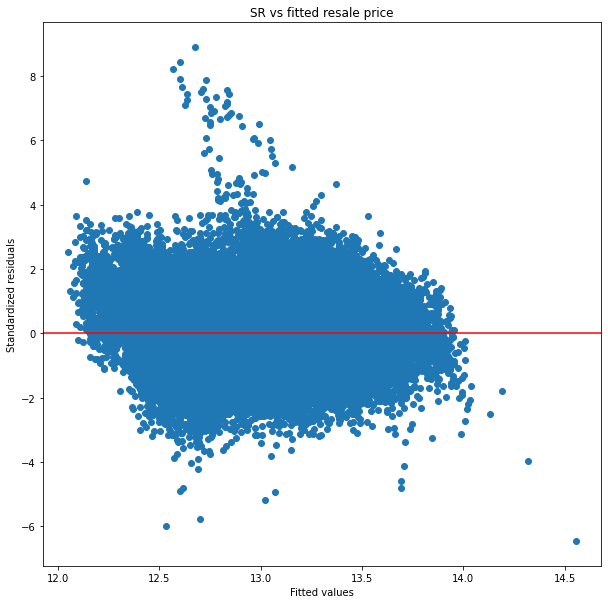

In [ ]:
#standard residual to fitted value
fig, ax = plt.subplots(figsize = [10,10])
influence = regmodel.get_influence()
s_res = influence.resid_studentized_internal
plt.scatter(lm2, s_res)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('SR vs fitted resale price')
plt.xlabel('Fitted values')
plt.ylabel('Standardized residuals')
plt.show()

In [ ]:
# we transform the back the resale price by performing exp on its values
lm1 = np.exp(lm1)
lm2 = np.exp(lm2)

test_y = np.exp(test_y)
train_y = np.exp(train_y)

In [ ]:
def mean_absolute_percentage_error(true, pred):
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

# R^2 score
print('r2 score for test: ', r2_score(test_y, lm1))
print('r2 score for train: ', r2_score(train_y, lm2))

# mean absolute error
print('mae for test: ', mean_absolute_error(test_y, lm1))
print('mae for train: ', mean_absolute_error(train_y, lm2))

# mean absolute percentage error
print('mape for test: ', mean_absolute_percentage_error(test_y, lm1), '%')
print('mape for train: ', mean_absolute_percentage_error(train_y, lm2), '%')

# mean square error
print('mse for test: ', mean_squared_error(test_y, lm1))
print('mse for train: ', mean_squared_error(train_y, lm2))

r2 score for test:  0.8724395199679779
r2 score for train:  0.8731996675064024
mae for test:  41157.40726360139
mae for train:  40796.443532624886
mape for test:  8.9687457109468 %
mape for train:  8.939201926658399 %
mse for test:  3126949656.4912324
mse for train:  3060680152.9692307


In [ ]:
last = {
    "Data " : ['Test','Train'],
    'R2 Score' : [0.872, 0.873],
    'MAPE' : ['8.969%', '8.939%'],
    'MAE' : [41157.40, 40796.44]
}
#Score for test and train dataset
display(pd.DataFrame(last))

,Data,R2 Score,MAPE,MAE
0,Test,0.872,8.969%,41157.40
1,Train,0.873,8.939%,40796.44


In [ ]:
tab = {'Prediction' : lm1,
       'Actual' : test_y, 
       'Difference' : (lm1 - test_y),
       'Percentage Difference' : ((lm1 - test_y)/ test_y) * 100}
df_res = pd.DataFrame(tab)
display(df_res)

,Prediction,Actual,Difference,Percentage Difference
82259,390382.410829,369500.0,20882.410829,5.651532
70383,318425.323236,365000.0,-46574.676764,-12.760185
54975,614768.688568,725000.0,-110231.311432,-15.204319
64863,308586.230956,308000.0,586.230956,0.190335
23225,333522.747625,330000.0,3522.747625,1.067499
...,...,...,...,...
97359,409925.319069,420000.0,-10074.680931,-2.398734
89572,341334.675474,322000.0,19334.675474,6.004558
31827,871797.574078,845000.0,26797.574078,3.171311
77376,498457.763948,520000.0,-21542.236052,-4.142738


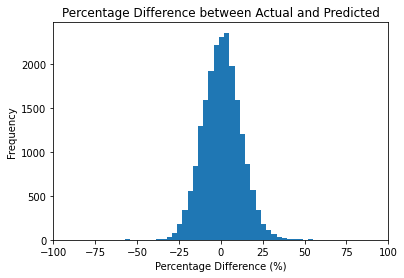

In [ ]:
#histogram of percentage difference between actual and predicted
plt.hist(df_res['Percentage Difference'], bins = 50)
plt.xlim(-100, 100)

plt.xlabel("Percentage Difference (%)")
plt.ylabel("Frequency")
_ = plt.title("Percentage Difference between Actual and Predicted")
plt.show()

Displaying the Model's Coefficients of the levels of each Categorical Data

In [ ]:
town = pd.DataFrame(regmodel.params[9:35], columns = ['coefficient'])
town.reset_index().rename(columns = {'index':'Town'})

town['difference compared to JurongWest'] = town['coefficient'] - regmodel.params[9:35].tolist()[13]
town['percentage difference compared to JurongWest'] =  ((regmodel.params[9:35].tolist()[13] - town['coefficient']) / regmodel.params[9:35].tolist()[13]) * 100
town['town premium'] = np.exp(town['difference compared to JurongWest'])
#coefficient for town
display(town)

,coefficient,difference compared to JurongWest,percentage difference compared to JurongWest,town premium
town_ANGMOKIO,-0.546979,0.278645,33.749612,1.321338
town_BEDOK,-0.709472,0.116153,14.068454,1.123167
town_BISHAN,-0.426029,0.399595,48.399098,1.491220
town_BUKITBATOK,-0.706691,0.118934,14.405292,1.126295
town_BUKITMERAH,-0.631828,0.193797,23.472729,1.213849
town_BUKITPANJANG,-0.704914,0.120710,14.620476,1.128298
town_BUKITTIMAH,-0.293387,0.532237,64.464776,1.702737
town_CENTRALAREA,-0.783455,0.042169,5.107542,1.043071
town_CHOACHUKANG,-0.771756,0.053868,6.524567,1.055346
town_CLEMENTI,-0.578186,0.247438,29.969794,1.280740


In [ ]:
## Note that the names are unsorted

storey = pd.DataFrame(regmodel.params[35:], columns = ['coefficient'])
storey.reset_index().rename(columns = {'index':'Storey'})

storey['difference compared to storey range of 01TO03'] = storey['coefficient'] - regmodel.params[35:].tolist()[0]
storey['percentage difference compared to storey range of 31TO33'] =  ((regmodel.params[35:].tolist()[0]- storey['coefficient'])/ regmodel.params[35:].tolist()[0]) * 100
storey['storey premium'] = np.exp(storey['difference compared to storey range of 01TO03'])
#coefficient for storey level
storey

,coefficient,difference compared to storey range of 01TO03,percentage difference compared to storey range of 31TO33,storey premium
storey_range_01TO03,-1.167044,0.000000,-0.000000,1.000000
storey_range_07TO09,-1.103190,0.063854,5.471443,1.065937
storey_range_10TO12,-1.082990,0.084055,7.202353,1.087688
storey_range_04TO06,-1.132468,0.034576,2.962694,1.035181
storey_range_13TO15,-1.065024,0.102020,8.741752,1.107406
storey_range_28TO30,-0.938231,0.228814,19.606248,1.257108
storey_range_16TO18,-1.038722,0.128322,10.995470,1.136919
storey_range_22TO24,-0.986052,0.180992,15.508572,1.198405
storey_range_19TO21,-0.996850,0.170195,14.583392,1.185536
storey_range_25TO27,-0.963506,0.203538,17.440452,1.225731


Duplicated Test cases on attributes - town and storey range


In [ ]:
towns = test_data.columns[9:35].tolist()
towns.remove('town_ANGMOKIO')

final = test_data.iloc[9:10].copy()
final['town_CENTRALAREA'] = 0
final['town_ANGMOKIO'] = 1

for name in towns:
  case = test_data.iloc[9:10].copy()
  case['town_CENTRALAREA'] = 0
  case[name] = 1
  final = pd.concat([final, case])

final.drop(columns = ['resale_price'], inplace = True )

final['predicted_price'] =  np.around(np.exp(regmodel.predict(final)))
final['towns'] = ['ANG MO KIO','BEDOK','BISHAN','BUKIT BATOK','BUKIT MERAH','BUKIT PANJANG','BUKIT TIMAH','CENTRAL AREA','CHOA CHU KANG','CLEMENTI','GEYLANG',
                  'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL', 'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG',
                  'SERANGOON','TAMPINES','TOA PAYOH','WOODLANDS','YISHUN']

df = final[['towns','floor_area_sqm',	'remaining_years', 'count_nearby_mrt',	'count_nearby_hawker', 'predicted_price']]
df.sort_values(['predicted_price'], inplace = True)

JW = df['predicted_price'].tolist()[0]
df['percentage diff compared to Jurong West'] = (((df['predicted_price'] - JW)/ JW) * 100).round(1)

df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,towns,floor_area_sqm,remaining_years,count_nearby_mrt,count_nearby_hawker,predicted_price,percentage diff compared to Jurong West
4270,JURONG WEST,107.0,90.687694,4,4,922536.0,0.0
4270,CENTRAL AREA,107.0,90.687694,4,4,962270.0,4.3
4270,CHOA CHU KANG,107.0,90.687694,4,4,973594.0,5.5
4270,SENGKANG,107.0,90.687694,4,4,1000984.0,8.5
4270,JURONG EAST,107.0,90.687694,4,4,1027249.0,11.4
4270,PASIR RIS,107.0,90.687694,4,4,1031239.0,11.8
4270,BEDOK,107.0,90.687694,4,4,1036162.0,12.3
4270,GEYLANG,107.0,90.687694,4,4,1037069.0,12.4
4270,BUKIT BATOK,107.0,90.687694,4,4,1039048.0,12.6
4270,BUKIT PANJANG,107.0,90.687694,4,4,1040895.0,12.8


In [ ]:
SR = sorted(test_data.columns[35:55].tolist())
SR.remove('storey_range_01TO03')

final = test_data.iloc[9:10].copy()
final['storey_range_37TO39'] = 0
final['storey_range_01TO03'] = 1

for name in SR:
  case = test_data.iloc[9:10].copy()
  case['storey_range_37TO39'] = 0
  case[name] = 1
  final = pd.concat([final, case])

final.drop(columns = ['resale_price'], inplace = True )

final['Predicted_Price'] =  np.around(np.exp(regmodel.predict(final)))
final['Storey Range'] = ['storey_range_01TO03',
                        'storey_range_04TO06',
                        'storey_range_07TO09',
                        'storey_range_10TO12',
                        'storey_range_13TO15',
                        'storey_range_16TO18',
                        'storey_range_19TO21',
                        'storey_range_22TO24',
                        'storey_range_25TO27',
                        'storey_range_28TO30',
                        'storey_range_31TO33',
                        'storey_range_34TO36',
                        'storey_range_37TO39',
                        'storey_range_40TO42',
                        'storey_range_43TO45',
                        'storey_range_46TO48',
                        'storey_range_49TO51']

df = final[['Storey Range','floor_area_sqm',	'remaining_years', 'count_nearby_mrt',	'count_nearby_hawker', 'Predicted_Price']]
df.sort_values(['Predicted_Price'], inplace = True)

FIR = df['Predicted_Price'].tolist()[0]
df['percentage diff compared to storey 1 to 3'] = (((df['Predicted_Price'] - FIR)/FIR) * 100).round(1)

df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Storey Range,floor_area_sqm,remaining_years,count_nearby_mrt,count_nearby_hawker,Predicted_Price,percentage diff compared to storey 1 to 3
4270,storey_range_01TO03,107.0,90.687694,4,4,735498.0,0.0
4270,storey_range_04TO06,107.0,90.687694,4,4,761373.0,3.5
4270,storey_range_07TO09,107.0,90.687694,4,4,783994.0,6.6
4270,storey_range_10TO12,107.0,90.687694,4,4,799992.0,8.8
4270,storey_range_13TO15,107.0,90.687694,4,4,814494.0,10.7
4270,storey_range_16TO18,107.0,90.687694,4,4,836201.0,13.7
4270,storey_range_19TO21,107.0,90.687694,4,4,871959.0,18.6
4270,storey_range_22TO24,107.0,90.687694,4,4,881425.0,19.8
4270,storey_range_25TO27,107.0,90.687694,4,4,901523.0,22.6
4270,storey_range_28TO30,107.0,90.687694,4,4,924600.0,25.7
